## Import Libs

In [1]:
!wget --no-check-certificate https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv

--2021-02-21 09:21:09--  https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/37u83g55p19kvrl/clean-phone-data-for-students.csv [following]
--2021-02-21 09:21:10--  https://www.dropbox.com/s/raw/37u83g55p19kvrl/clean-phone-data-for-students.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c873f7c9b690ba7e4ae4c03d1.dl.dropboxusercontent.com/cd/0/inline/BJXF2mym2QzdWtSQN8CiI2t7DzttvGaNaRsf8-AiJNygfVXiFQTRx9sjTogy1jMiD9tvNF3r4_3YKoou7EA2AG9aEo6GQn1IMiuEZipJgBGR7w/file# [following]
--2021-02-21 09:21:10--  https://uc7c873f7c9b690ba7e4ae4c03d1.dl.dropboxusercontent.com/cd/0/inline/BJXF2mym2QzdWtSQN8CiI2t7DzttvGaNaRsf8-AiJNygfVXiFQTRx9sjTogy1jMiD9tvN

In [2]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt

## Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

**Note: the data is provided courtesy of TrueVoice and must be used for educational purposes only**

In [3]:
phone_df = pandas.read_csv('clean-phone-data-for-students.csv')

Let's preview the data.

In [4]:
# Show the top 5 rows
display(phone_df.head())
# Summarize the data
phone_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## Data cleaning

We first select only the columns we are interested.

For this example we will be training a model to predict the "Object" given a "Sentence Utterance". Thus we will be only selecting these two. Others can also be selected, but these two will serve as an example.

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

In [5]:
data_df = phone_df[["Sentence Utterance", "Object"]]
data_df.columns = ['input', 'raw_label']
display(data_df.describe())
display(data_df.raw_label.unique())

,input,raw_label
count,16175,16175
unique,13389,33
top,บริการอื่นๆ,service
freq,97,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

### Removing duplicated labels

from above, we can see that there are 33 unique labels

But we want to make sure that these label are really unique from one another not just how capital letters are used

In [6]:
data_df['clean_label']=data_df['raw_label'].str.lower().copy()
display(data_df.describe())
display(data_df.clean_label.unique())



,input,raw_label,clean_label
count,16175,16175,16175
unique,13389,33,26
top,บริการอื่นๆ,service,service
freq,97,2525,2528


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage',
       'ringtone', 'rate', 'loyalty_card', 'contact', 'officer'],
      dtype=object)

In [7]:
#we no longer need raw_label column
data_df.drop('raw_label', axis=1, inplace=True)
display(data_df.describe())

,input,clean_label
count,16175,16175
unique,13389,26
top,บริการอื่นๆ,service
freq,97,2528


### Remove duplicates input

There are some duplicates in the input of this dataset.

In [8]:
display(data_df.describe())

,input,clean_label
count,16175,16175
unique,13389,26
top,บริการอื่นๆ,service
freq,97,2528


As you can see above, we no longer have unwanted duplicated in our labels

But there are still duplicates in our input. 7 rows with "สอบถามยอดค้างชำระค่ะ"

We will remove them now, by keeping only the first entry.

In [9]:
data_df = data_df.drop_duplicates("input", keep="first")
display(data_df.describe())

,input,clean_label
count,13389,13389
unique,13389,26
top,สอบถามโปรโมชั่นอินเตอร์เน็ต,service
freq,1,2111


### Substitute Strings in Label
Computer don't actually understand the string in the label so we will substitute them with a number for each unique value.

In [12]:
data = data_df.to_numpy()

unique_label = data_df.clean_label.unique()

label_2_num_map = dict(zip(unique_label, range(len(unique_label))))
num_2_label_map = dict(zip(range(len(unique_label)), unique_label))

print("Create Mappings")
display(num_2_label_map)
display(label_2_num_map)

print("Before Mappings")
display(data[:, 1])
data[:,1] = np.vectorize(label_2_num_map.get)(data[:,1])

print("After Mappings")
display(data[:, 1])

Create Mappings


{0: 'payment',
 1: 'package',
 2: 'suspend',
 3: 'internet',
 4: 'phone_issues',
 5: 'service',
 6: 'nontruemove',
 7: 'balance',
 8: 'detail',
 9: 'bill',
 10: 'credit',
 11: 'promotion',
 12: 'mobile_setting',
 13: 'iservice',
 14: 'roaming',
 15: 'truemoney',
 16: 'information',
 17: 'lost_stolen',
 18: 'balance_minutes',
 19: 'idd',
 20: 'garbage',
 21: 'ringtone',
 22: 'rate',
 23: 'loyalty_card',
 24: 'contact',
 25: 'officer'}

{'balance': 7,
 'balance_minutes': 18,
 'bill': 9,
 'contact': 24,
 'credit': 10,
 'detail': 8,
 'garbage': 20,
 'idd': 19,
 'information': 16,
 'internet': 3,
 'iservice': 13,
 'lost_stolen': 17,
 'loyalty_card': 23,
 'mobile_setting': 12,
 'nontruemove': 6,
 'officer': 25,
 'package': 1,
 'payment': 0,
 'phone_issues': 4,
 'promotion': 11,
 'rate': 22,
 'ringtone': 21,
 'roaming': 14,
 'service': 5,
 'suspend': 2,
 'truemoney': 15}

Before Mappings


array(['payment', 'package', 'suspend', ..., 'balance', 'balance',
       'package'], dtype=object)

After Mappings


array([0, 1, 2, ..., 7, 7, 1], dtype=object)

### String cleaning
Trim whitespace

In [13]:
def strip_str(string):
    return string.strip()
     
# Trim of extra begining and trailing whitespace in the string
print("Before")
print(data)
data[:,0] = np.vectorize(strip_str)(data[:,0])
print("After")
print(data)

Before
[[' <PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท'
  0]
 [' internet ยังความเร็วอยุ่เท่าไหร ครับ' 1]
 [' ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ' 2]
 ...
 ['ยอดเงินเหลือเท่าไหร่ค่ะ' 7]
 ['ยอดเงินในระบบ' 7]
 ['สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ' 1]]
After
[['<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท'
  0]
 ['internet ยังความเร็วอยุ่เท่าไหร ครับ' 1]
 ['ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ' 2]
 ...
 ['ยอดเงินเหลือเท่าไหร่ค่ะ' 7]
 ['ยอดเงินในระบบ' 7]
 ['สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ' 1]]


### Visualize Class Count

We will now visualize the class imbalance. Note that training directly on imbalance dataset can yield bad results. 

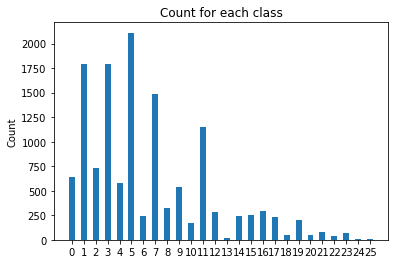

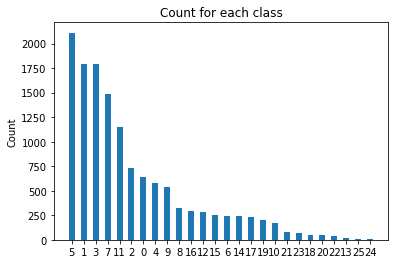

In [14]:
def plot(label, count):
    fig, ax = plt.subplots()
    ind = np.arange(len(count))
    rects1 = ax.bar(ind, count, 0.5)

    ax.set_ylabel('Count')
    ax.set_title('Count for each class')
    ax.set_xticks(ind)
    ax.set_xticklabels(label)

    plt.show()
    
label, count = np.unique(data[:, 1], return_counts=True)
plot(label, count)

# pack the label and count together
bundle = list(zip(label, count))
# sort them by count
bundle = sorted(bundle, key=lambda e: e[1], reverse=True) 
# unpack the values
label, count = zip(*bundle)
plot(label, count)

Now we have our training data with input and labels

## Feature Engineering

Which is just a fancy word for making the input work with our model.

The models that we are going to tackle do not accpet varying size input, so we have to transform our input in some ways that makes the input have this property while also retaining some useful information.

### Feature #1: Char count

#### Finding the Chars
We will first find the list of possible chars in the dataset, we can just Google all the possible chars in Thai and English or we can just obtain it from the data set. The code bellow will do the latter.

In [15]:
all_the_string = "".join(data[:, 0])

np_str = np.array(list(all_the_string))
all_char = np.unique(np_str)

sorted(all_char)
print("There are %d unique chars in the data set" % len(all_char))
print(all_char)
char_map = dict(zip(all_char, range(len(all_char))))

There are 152 unique chars in the data set
['\n' ' ' '"' '#' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2'
 '3' '4' '5' '6' '7' '8' '9' '<' '>' '?' '@' 'A' 'B' 'C' 'D' 'E' 'F' 'G'
 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' '_'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' 'é' 'ก' 'ข' 'ฃ' 'ค' 'ฆ' 'ง' 'จ' 'ฉ' 'ช'
 'ซ' 'ฌ' 'ญ' 'ฎ' 'ฐ' 'ฑ' 'ฒ' 'ณ' 'ด' 'ต' 'ถ' 'ท' 'ธ' 'น' 'บ' 'ป' 'ผ' 'ฝ'
 'พ' 'ฟ' 'ภ' 'ม' 'ย' 'ร' 'ฤ' 'ล' 'ว' 'ศ' 'ษ' 'ส' 'ห' 'ฬ' 'อ' 'ฮ' 'ฯ' 'ะ'
 'ั' 'า' 'ำ' 'ิ' 'ี' 'ึ' 'ื' 'ุ' 'ู' 'ฺ' 'เ' 'แ' 'โ' 'ใ' 'ไ' 'ๆ' '็' '่'
 '้' '๊' '๋' '์' 'ํ' '“' '”' '…']


In [16]:
def count_str(string):
    global all_char, char_map
    result = np.zeros(len(all_char))
    np_str = np.array(list(string))
    str_char, str_char_count = np.unique(np_str, return_counts=True)
    for char, count in zip(str_char, str_char_count):
        result[char_map[char]] = count
    return result

# run example feature transformation
print("Example String to feature conversion")
display(data[0, 0])
display(count_str(data[0, 0]))

Example String to feature conversion


'<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท'

array([0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
       2., 2., 0., 2., 1., 3., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 4.,
       0., 0., 1., 0., 0., 0., 0., 2., 2., 2., 1., 2., 1., 0., 1., 1., 0.,
       0., 0., 2., 0., 0., 1., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 2., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2.,
       0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 5.,
       0., 3., 3., 1., 2., 0., 0., 0., 0., 4., 3., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 5., 0., 1., 4., 0., 1., 0., 1., 0.,
       5., 0., 0., 0., 1., 0., 2., 5., 1., 0., 0., 1., 0., 0., 0., 0.])

In [17]:
# run on data set
temp = np.vectorize(count_str, otypes=[object])(data[:, 0])
x_f1 = np.array([[e for e in sl] for sl in temp.tolist()])
label = data[:, 1]
print("Data")
print("Data shape", x_f1.shape)
print("label shape", label.shape)

Data
Data shape (13389, 152)
label shape (13389,)


### Feature #2: Keyword Detection

Code bellow will show the first 3 entries for each class

Use this to find some keywords that you believe will useful for the classifer.

In [18]:
def show_first_in_label(first, select_label):
    print("Showing label \"%s\"" % num_2_label_map[select_label])
    select = data[data[:, 1] == select_label, 0]
    for i in range(min(first, len(select))):
        print(i, select[i])
    print("")
        
first_three = 3
number_of_classes = 26
for i in range(number_of_classes):
    show_first_in_label(first_three, i)

Showing label "payment"
0 <PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท
1 <PHONE_NUMBER_REMOVED> เติมบัตรไม่ได้เลย
2 <PHONE_NUMBER_REMOVED> ลูกค้าเติมเงินที่ <PHONE_NUMBER_REMOVED> เติมไป 150 บาท เงินของเค้าถูกตัด เค้าไม่เข้าใจว่าถูกตัดค่าอะไรไปค่ะ

Showing label "package"
0 internet ยังความเร็วอยุ่เท่าไหร ครับ
1 <PHONE_NUMBER_REMOVED> เป็นเติมเงินนะคะ เดี๋ยวนี้วันหมดอายุ ต้องขอต่ออีกหรือไม่คะ
2 <PHONE_NUMBER_REMOVED> ใช้โปรอะไรอยู่ค่ะ

Showing label "suspend"
0 ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
1 <PHONE_NUMBER_REMOVED> หมายเลขนี้โดนระงับบริการเหรอค่ะ
2 <PHONE_NUMBER_REMOVED> โดนตัดสัญญาณหรือเปล่าครับ โทรเข้าออกไม่ได้

Showing label "internet"
0 พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง โกลไล
1 <PHONE_NUMBER_REMOVED> เค้าบอกจะส่งรหัสเน็ตมาให้ แต่ยังไม่ได้ส่งมาเลยค่ะ
2 <PHONE_NUMBER_REMOVED> รหัส ทรู ไวไฟ

Showing label "phone_issues"
0 ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโทรออกไม่ไ

Here are some of the entries used to find keywords.

In [19]:
index = 30
display(data[index, 0], num_2_label_map[data[index, 1]])

index = 40
display(data[index, 0], num_2_label_map[data[index, 1]])

index = 80
display(data[index, 0], num_2_label_map[data[index, 1]])

'<PHONE_NUMBER_REMOVED> ไม่ทราบว่ามันโทรออกไม่ได้เพราะอะไร เพราะพึ่งไปชำระเงินมา'

'phone_issues'

'<PHONE_NUMBER_REMOVED> ใช้เบอร์เล่นอินเตอร์เน็ตอยู่ มันเป็นแอร์การ์ด จะยกเลิกอ่ะครับ'

'service'

'Upgrade Firmware / Restore เครื่อง'

'mobile_setting'

Add keywords here, some are already added for you as an example. 
The transformed features (keywords) should differentiate each classes from one another. See bellow that the 3 entries each from 3 classes can be differentiate using the keywords added as an example.

In [20]:
keywords = ["โปร", "โทร", "ไม่ได้", "iservice","อินเตอร์เน็ต"]

The "has_keyword" function only detects the keyword. But you can also experiment with counting the occurrence of the keyword by modifying the function bellow.

In [21]:
def has_keyword(string):
    global keywords
    result = np.zeros(len(keywords))
    for index, keyword in enumerate(keywords):
        if keyword in string:
            result[index] = 1
    return result

def preview(string_ind):
    print("Entry")
    display(data[string_ind, 0])
    print("Feature")
    print(has_keyword(data[string_ind, 0]), "->", num_2_label_map[data[string_ind, 1]])
    print("")

# run example feature transformation
print("Example String to feature conversion\n\n")
preview(30)
preview(40)
preview(80)

Example String to feature conversion


Entry


'<PHONE_NUMBER_REMOVED> ไม่ทราบว่ามันโทรออกไม่ได้เพราะอะไร เพราะพึ่งไปชำระเงินมา'

Feature
[0. 1. 1. 0. 0.] -> phone_issues

Entry


'<PHONE_NUMBER_REMOVED> ใช้เบอร์เล่นอินเตอร์เน็ตอยู่ มันเป็นแอร์การ์ด จะยกเลิกอ่ะครับ'

Feature
[0. 0. 0. 0. 1.] -> service

Entry


'Upgrade Firmware / Restore เครื่อง'

Feature
[0. 0. 0. 0. 0.] -> mobile_setting



In [22]:
# run on data set
temp = np.vectorize(has_keyword, otypes=[object])(data[:, 0])
x_f2 = np.array([[e for e in sl] for sl in temp.tolist()])
label = data[:, 1].astype(int)
print("Data")
print("Data shape", x_f2.shape)
print("label shape", label.shape)

Data
Data shape (13389, 5)
label shape (13389,)


### Playing around
See how well the model can fit to our current data. This is a quick and dirty way of testing hand crafted features. The model will not generalize if it does not fit in the first place. We (you) will do proper training later.

In [23]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_f1, label)
y_pred = model.predict(x_f1)
print("Model Acc. on train data %f%%"
       % ((label == y_pred).sum() / x_f1.shape[0] * 100))

Model Acc. on train data 47.778027%


In [24]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_f2, label)
y_pred = model.predict(x_f2)
print("Model Acc. on train data %f%%"
       % ((label == y_pred).sum() / x_f1.shape[0] * 100))

Model Acc. on train data 26.805587%


### Training

#### Feature #1
##### Split  data into train-data test-data

In [25]:
from sklearn.model_selection import train_test_split
train_f1, test_f1 = train_test_split(x_f1, test_size=0.2,random_state=42)
train_label, test_label = train_test_split(label, test_size=0.2,random_state=42)

##### Train model

In [26]:
model = MultinomialNB()
model.fit(train_f1, train_label)
y_pred = model.predict(test_f1)


#### Display model performance
Accuracy, confusion-matrix, etc.

In [27]:
print("Model Acc. on train data %f%%"
       % ((test_label == y_pred).sum() / test_f1.shape[0] * 100))

Model Acc. on train data 44.996266%


Confusion matrix, without normalization
Normalized confusion matrix


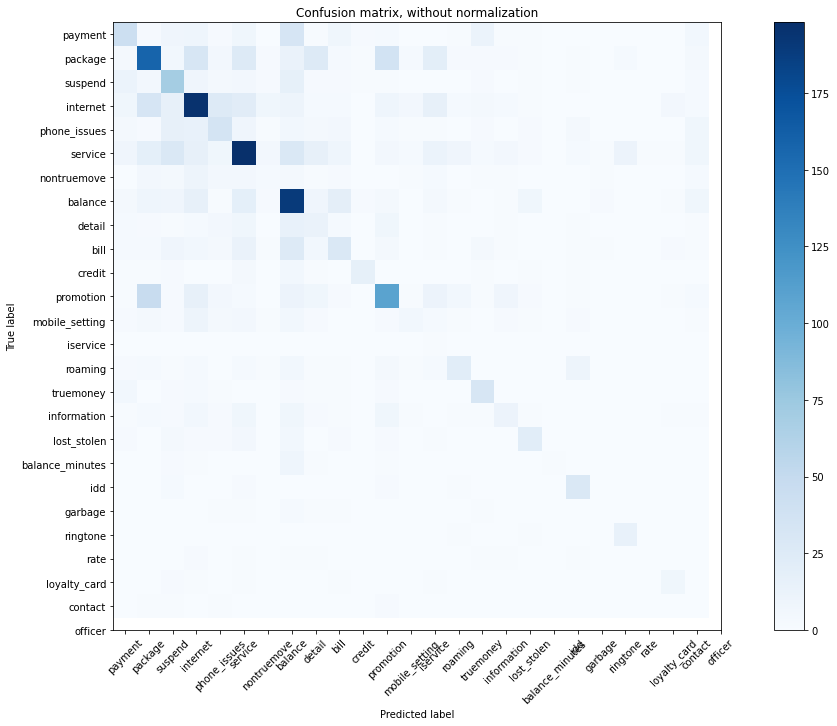

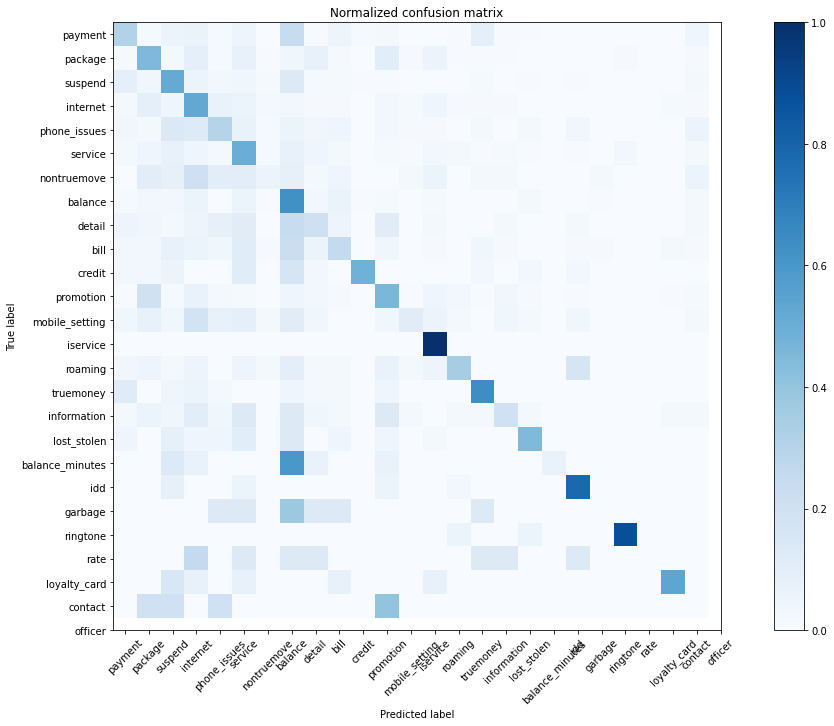

In [28]:
import itertools
from sklearn.metrics import confusion_matrix
#Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cnf_matrix = confusion_matrix(test_label, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=unique_label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=unique_label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



#### Feature #2
##### Split  data into train-data test-data

In [29]:
train_f2, test_f2 = train_test_split(x_f2, test_size=0.2,random_state=42)
#train_label, test_label = train_test_split(label, test_size=0.2,random_state=42)

##### Train model

In [30]:
model = MultinomialNB()
model.fit(train_f2, train_label)
y_pred = model.predict(test_f2)

##### Display model performance

In [31]:
print("Model Acc. on train data %f%%"
       % ((test_label == y_pred).sum() / test_f1.shape[0] * 100))

Model Acc. on train data 25.578790%


#### Try combining the 2 features

In [32]:
x_comb = np.concatenate((x_f1, x_f2), axis=1)
train_comb, test_comb = train_test_split(x_comb, test_size=0.2,random_state=42)
model = MultinomialNB()
model.fit(train_comb, train_label)
y_pred = model.predict(test_comb)
print("Model Acc. on train data %f%%"
       % ((test_label == y_pred).sum() / test_comb.shape[0] * 100))


Model Acc. on train data 46.191187%


#### Can you get more than 50% accuracy with Naive Bayes?